In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os


In [3]:
# Directory path containing the ROOT files
directory_path = '/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal'

# Define the specific files you want to include (with subdirectories)
desired_files = [
    'ee/ee_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root',
    
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root'
]

# Construct the full paths for the desired files
file_paths = [os.path.join(directory_path, filename) for filename in desired_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees = [uproot.open(file_path)['ttBar_treeVariables_step0'] for file_path in file_paths]

# Concatenate the TTrees from all files into a single TTree
file = uproot.concatenate(trees)

In [5]:
file

<Array [{top_pt: -999, top_phi: ..., ...}, ...] type='5471302 * {top_pt: fl...'>

In [4]:
mg_weight=file['mgWeights']

In [5]:
#Obtain the structure constant
import Event_weight_prediction
SC1= Event_weight_prediction.obtain_structure_constant(16, mg_weight)



In [6]:
import Data_store
Data_store.save_structure_constants(SC1, save_file='/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k')

Structure constants saved to /depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k


In [6]:
import numpy as np
SC_saved = np.load('/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k.npy', allow_pickle=True)


In [7]:
import Event_weight_prediction
#compute event weight for your desired WC value
wc_name =['ctGRe', 'ctGIm', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']   
ctgRe2 = [2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #ctgRe=2
sm=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #sm
ctgRe_neg2 = [-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
ctgRe_neg2_ctu8_neg2 = [-2,0,0,0,0,0,-2,0,0,0,0,0,0,0,0,0]
ctgRe15=[15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
ctgIm15=[0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0]


ctgRe15, ctgRe15_lin, ctgRe15_quad= Event_weight_prediction.event_weights_lin_quad(SC_saved, ctgRe15)
sm_weight,_,_=Event_weight_prediction.event_weights_lin_quad(SC_saved, sm)
#ctgRe15, ctgRe15_lin, ctgRe15_quad= Event_weight_total_lin_quad.event_weights(SC_saved, ctgRe15)
#ctgIm15, ctgIm15_lin, ctgIm15_quad= Event_weight_total_lin_quad.event_weights(SC_saved, ctgIm15)

In [8]:
sm_branch=mg_weight[:,200]

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mplhep as hep

def plot_weight_validation(weight_data_dict, bins_space=(0.1, 2), n_bins=60):
    """
    Plot two weight histograms and their ratio on a log x-axis.

    Parameters:
    - weight_data_dict: Dictionary with exactly two items {label: weights_array}.
    - bins_space: (min, max) range for x-axis.
    - n_bins: Number of bins.
    """
    assert len(weight_data_dict) == 2, "Provide exactly two weight datasets for comparison."

    # Extract the two datasets
    labels = list(weight_data_dict.keys())
    w1, w2 = weight_data_dict[labels[0]], weight_data_dict[labels[1]]

    # Define log-spaced bins
    bins = np.logspace(np.log10(bins_space[0]), np.log10(bins_space[1]), n_bins)

    # Histogram the weights
    hist1, _ = np.histogram(w1, bins=bins)
    hist2, _ = np.histogram(w2, bins=bins)

    # Midpoints for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = np.diff(bins)

    # Convert to NumPy arrays (in case they are awkward Arrays)
    hist1 = np.asarray(hist1)
    hist2 = np.asarray(hist2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.divide(hist1, hist2)
        ratio[~np.isfinite(ratio)] = 0  # set NaN/inf to zero


    # Use CMS style
    plt.style.use(hep.style.CMS)

    # Create figure with ratio subplot
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)

    # Main plot
    ax_main.hist(w1, bins=bins, histtype='stepfilled', label=labels[0], color='blue')
    ax_main.hist(w2, bins=bins, histtype='step', label=labels[1], color='red')
    ax_main.set_ylabel("Number of Events")
    #ax_main.set_xscale("log")
    ax_main.legend()
    hep.cms.text("Preliminary", ax=ax_main)

    # Ratio plot
    ax_ratio.step(bin_centers, ratio, where="mid", color="black")
    ax_ratio.set_xlabel("Weight")
    ax_ratio.set_ylabel("Ratio")
    #ax_ratio.set_xscale("log")
    ax_ratio.axhline(1.0, linestyle="--", color="gray", linewidth=1)

    plt.setp(ax_main.get_xticklabels(), visible=False)
    plt.show()


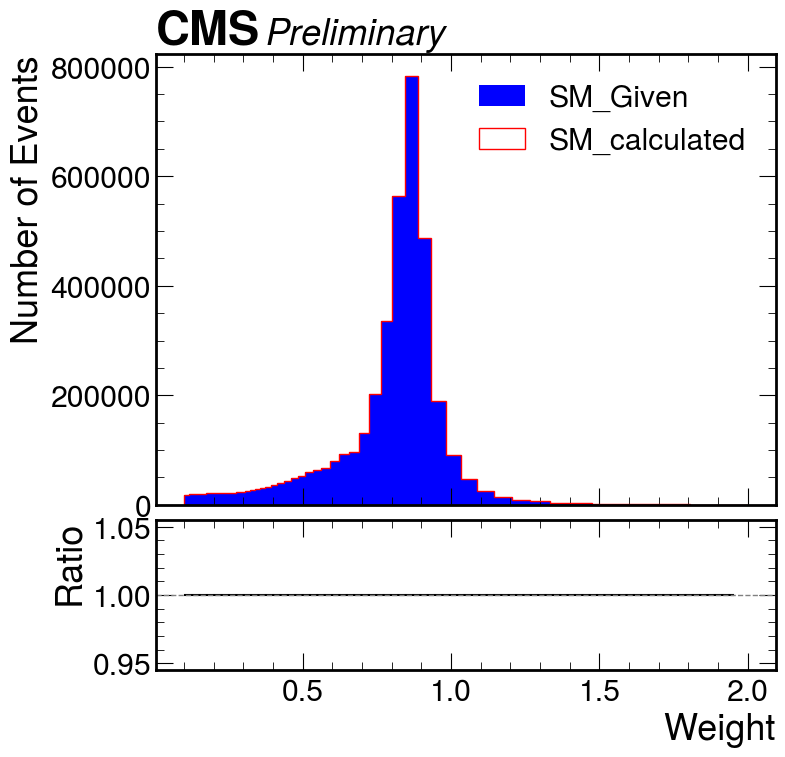

In [20]:
weight_data_dict = {
    'SM_Given': sm_branch,
    'SM_calculated':sm_weight,       
}
plot_weight_validation(weight_data_dict)

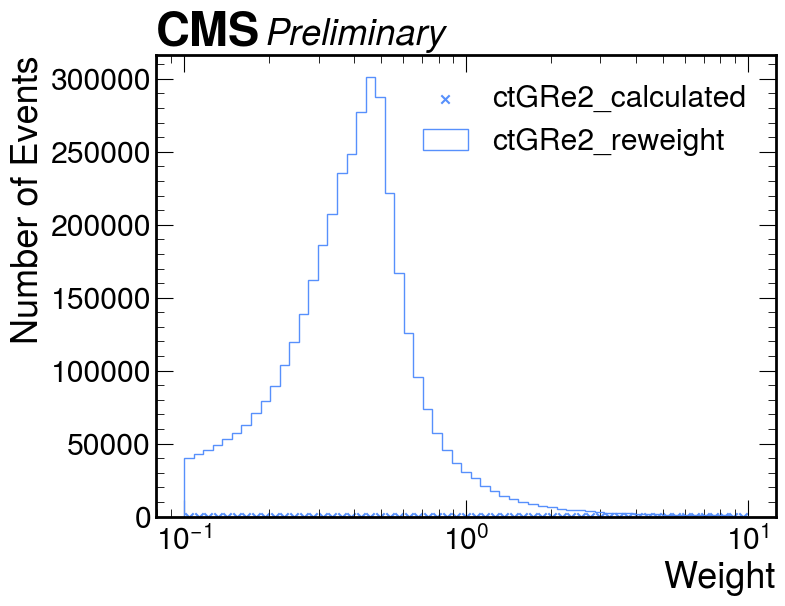

In [13]:
import plotting__script2
weight_data_dict = {
    'ctGRe2_calculated': ctgRe2,
    'ctGRe2_reweight':ctgRe2_reweight,
    
    
}
plotting__script2.plot_weight_validation(weight_data_dict)

<>:42: SyntaxWarning: invalid escape sequence '\p'
<>:42: SyntaxWarning: invalid escape sequence '\p'
<>:42: SyntaxWarning: invalid escape sequence '\p'
<>:42: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2194/3996520053.py:42: SyntaxWarning: invalid escape sequence '\p'
  'gen_ll_cHel': ('gen_$cos\phi$', 'gen_$cos\phi$'),
/tmp/ipykernel_2194/3996520053.py:42: SyntaxWarning: invalid escape sequence '\p'
  'gen_ll_cHel': ('gen_$cos\phi$', 'gen_$cos\phi$'),


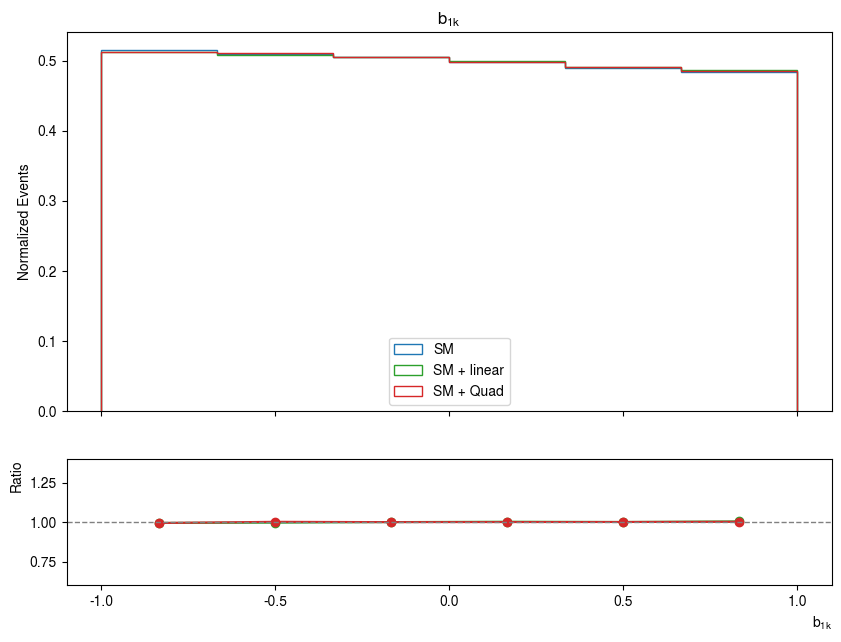

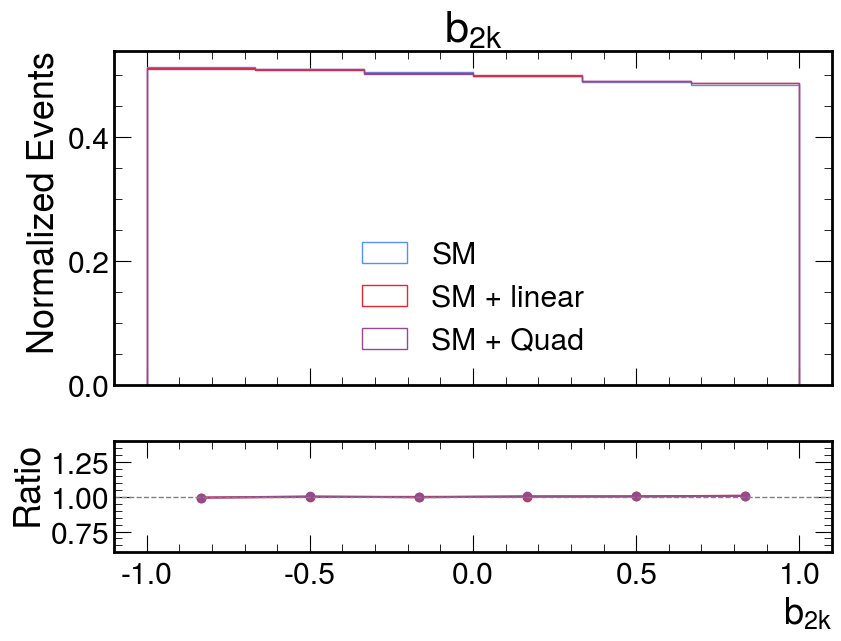

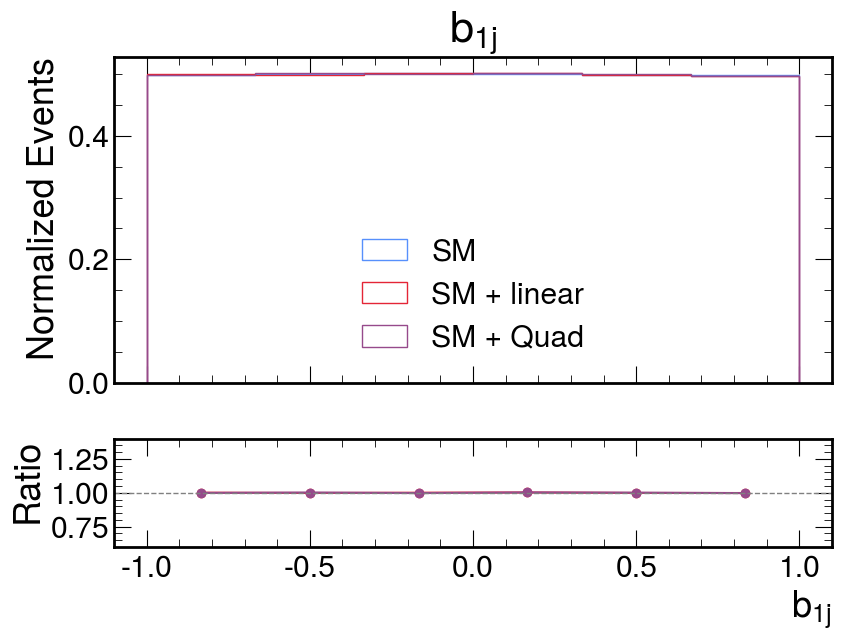

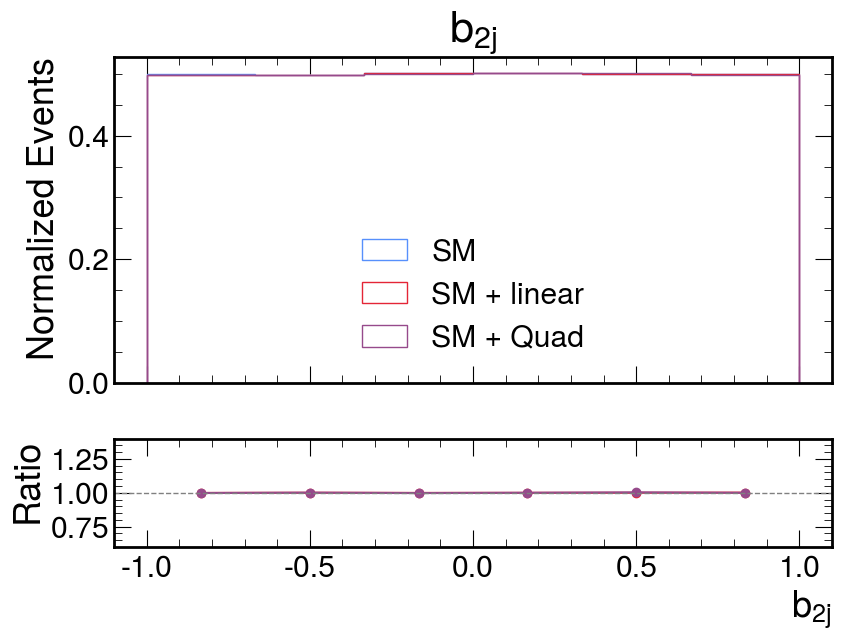

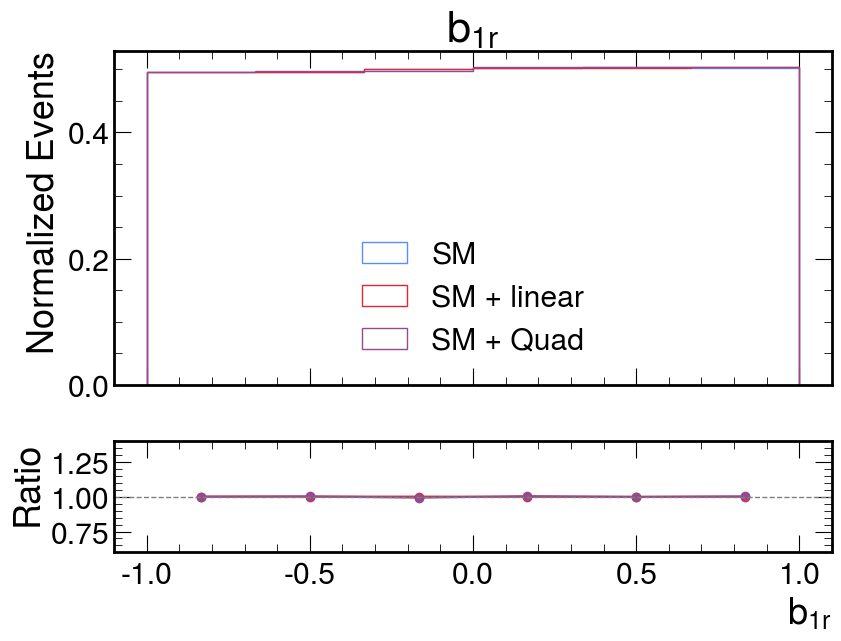

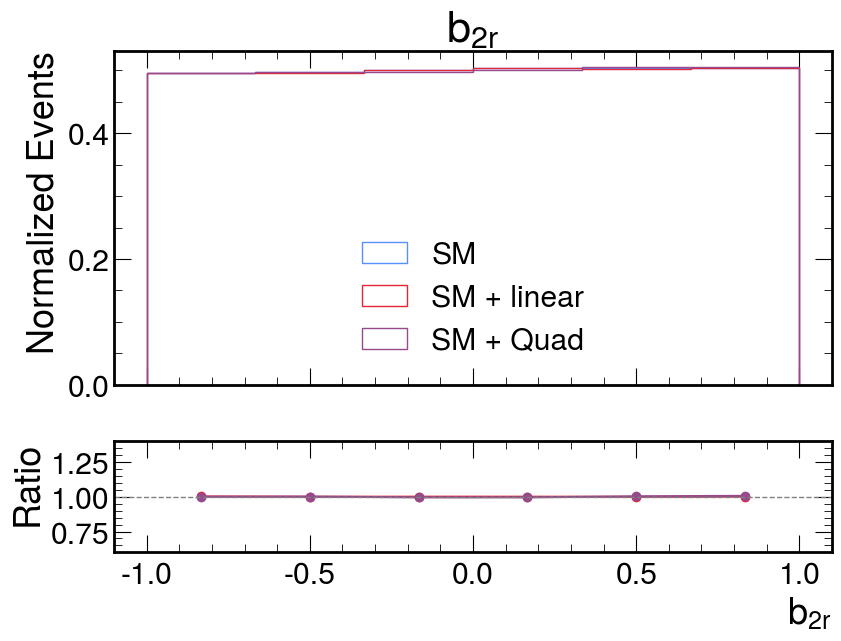

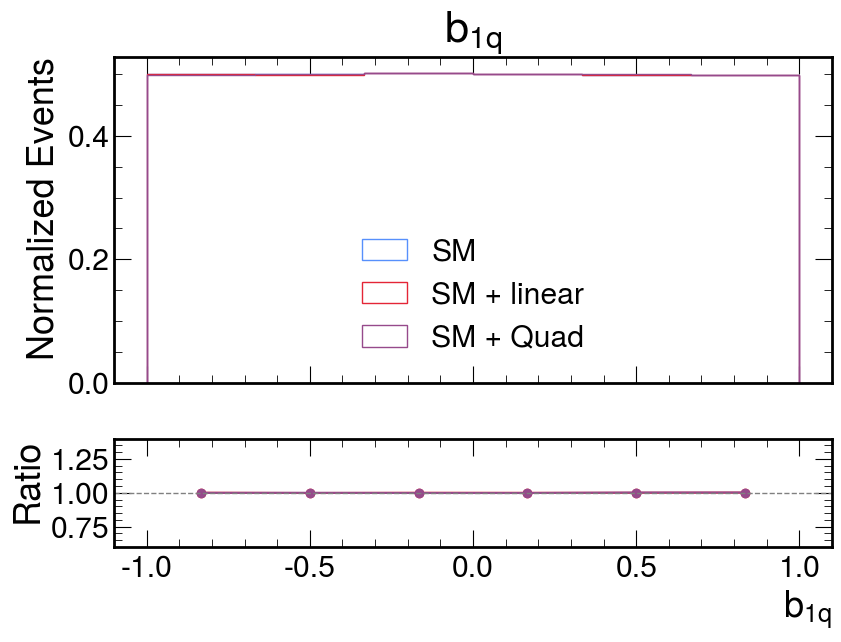

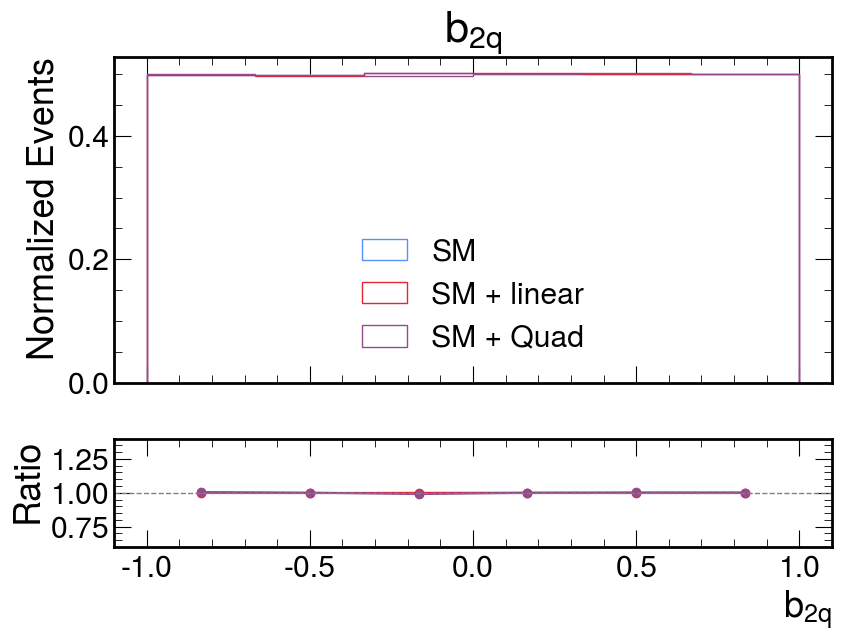

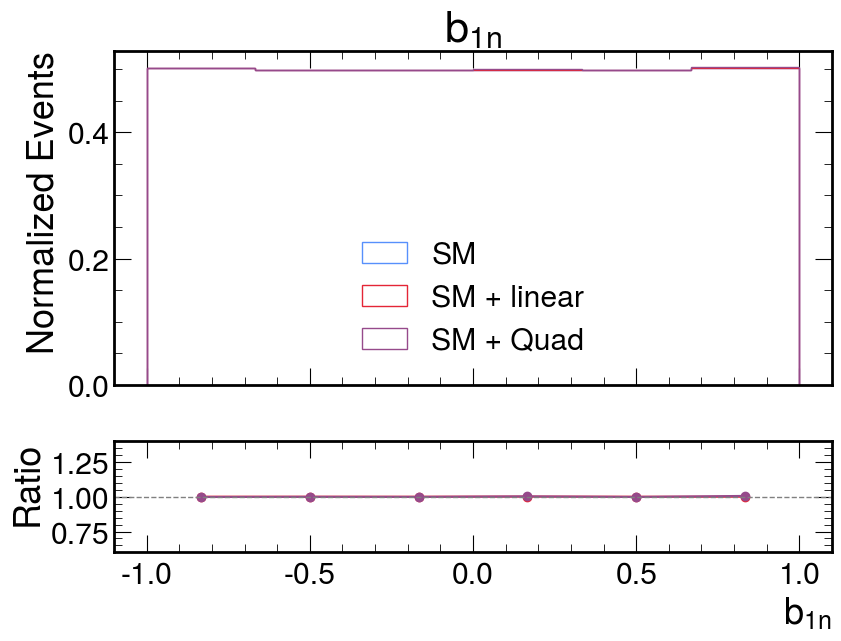

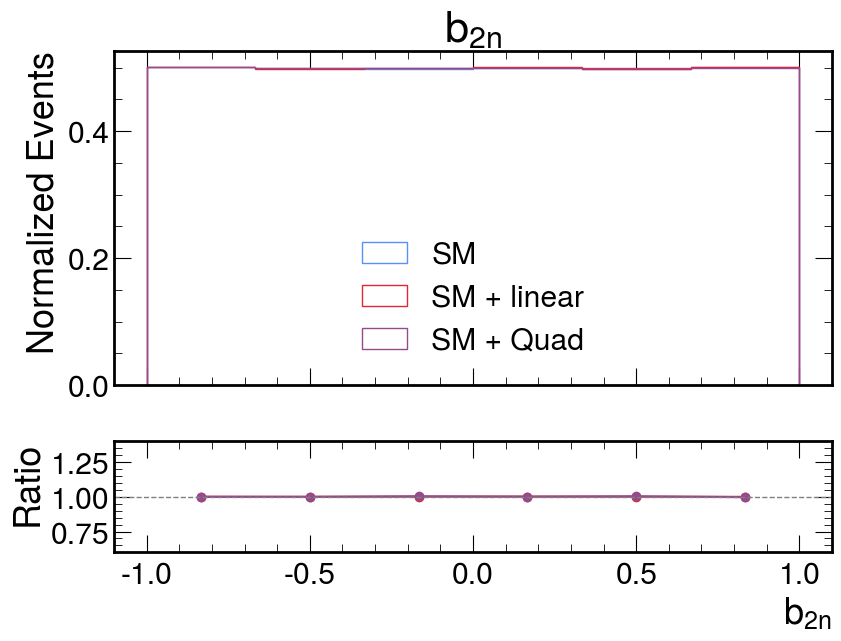

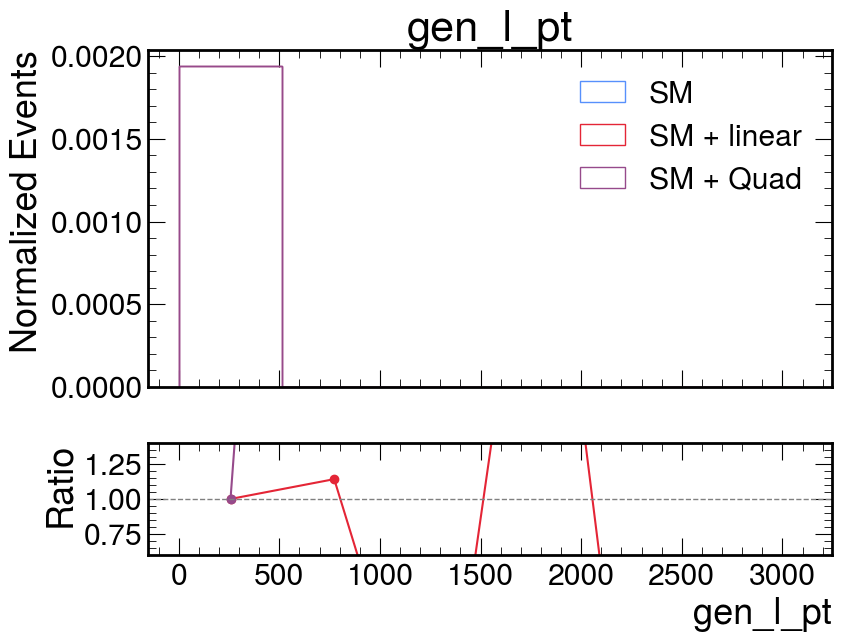

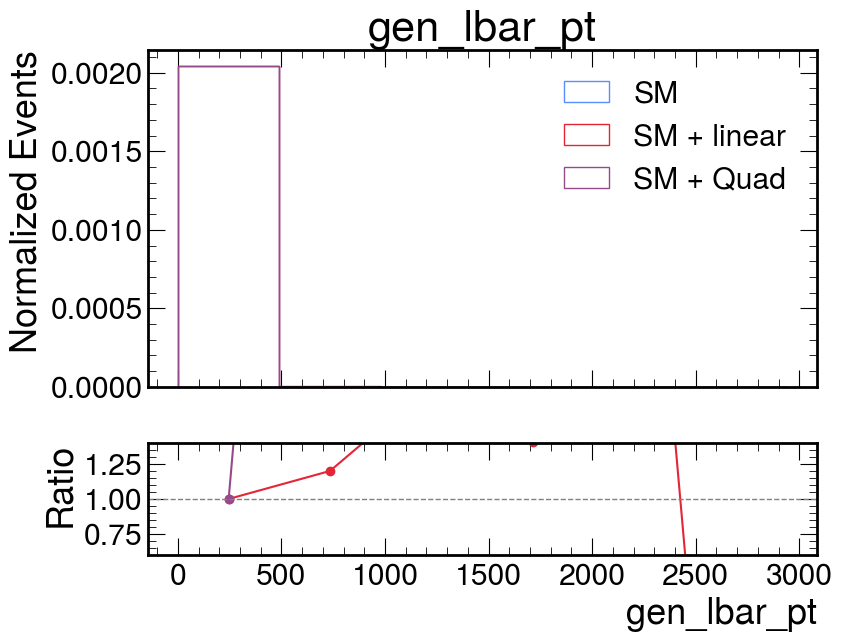

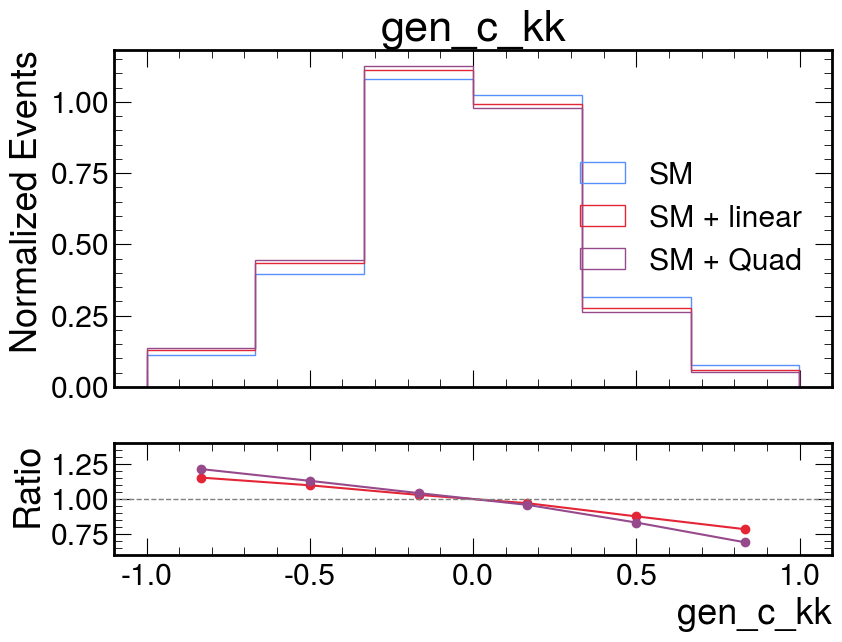

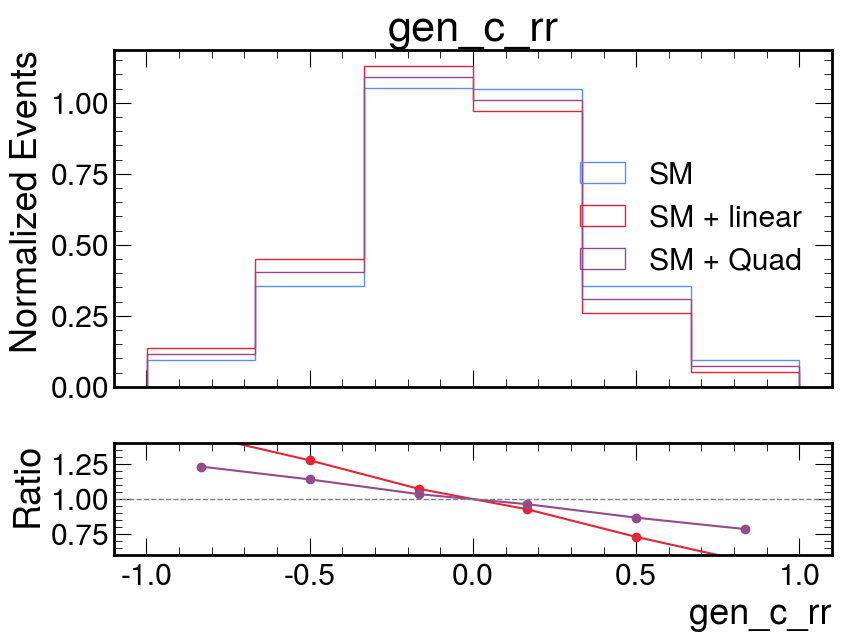

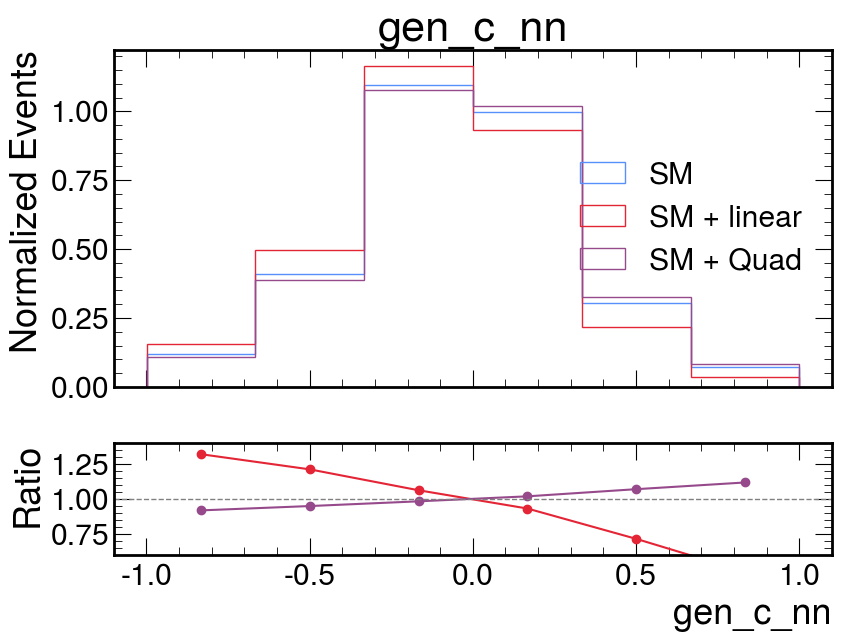

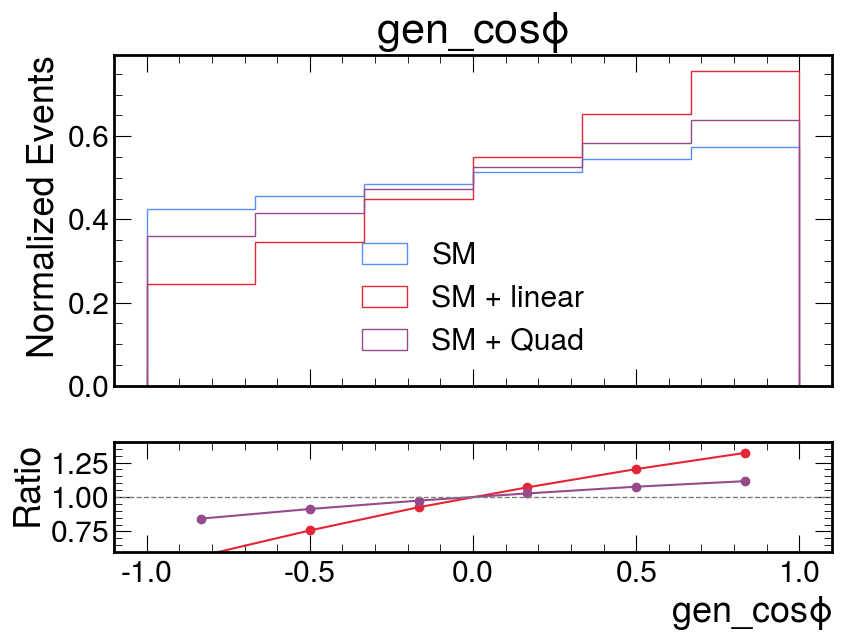

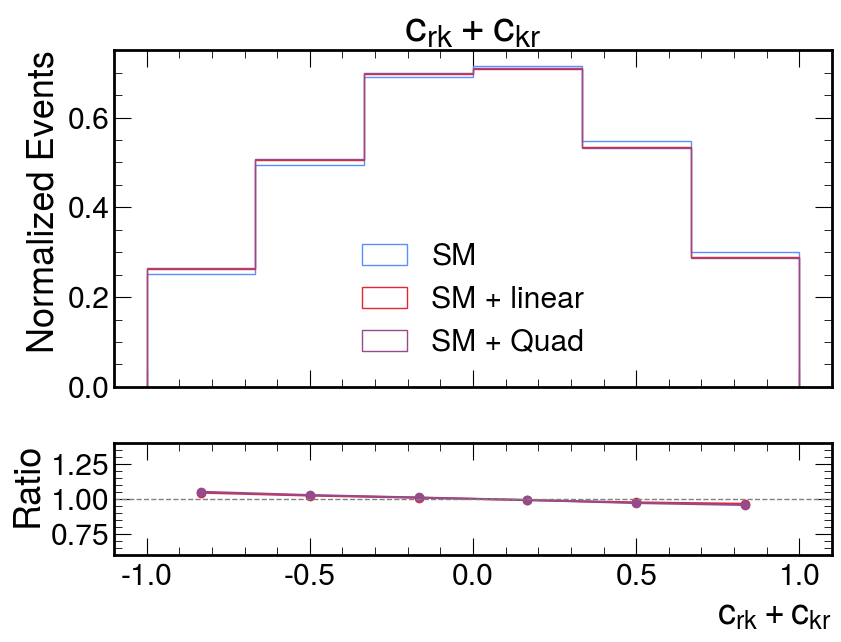

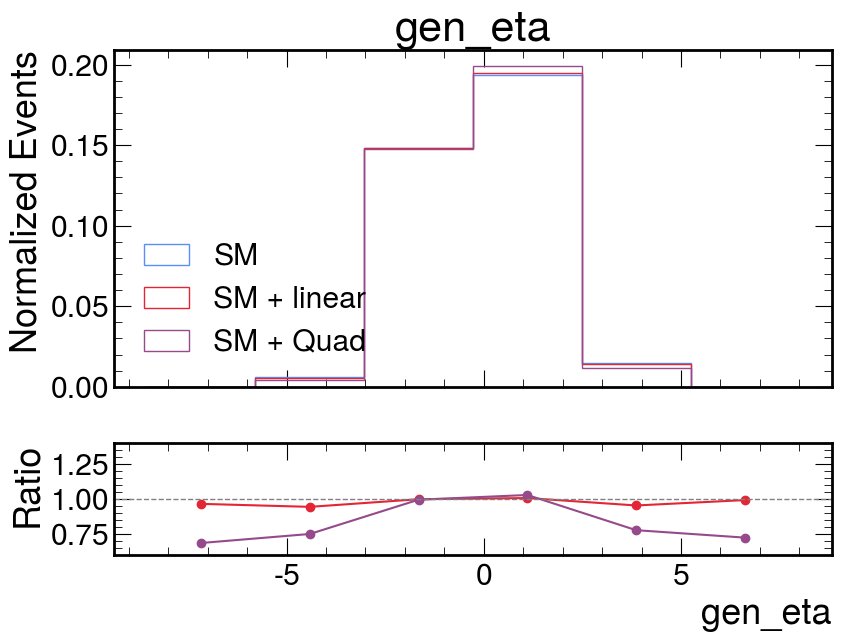

In [7]:
import plotting__script2
#Plotting the reweighted sm vs eft points
observables = {
    'gen_ttbar_mass': file['gen_ttbar_mass'],
    'gen_b1k': file['gen_b1k'],
    'gen_b2k': file['gen_b2k'],
    'gen_b1j': file['gen_b1j'],
    'gen_b2j': file['gen_b2j'],
    'gen_b1r': file['gen_b1r'],
    'gen_b2r': file['gen_b2r'],
    'gen_b1q': file['gen_b1q'],
    'gen_b2q': file['gen_b2q'],
    'gen_b1n': file['gen_b1n'],
    'gen_b2n': file['gen_b2n'],
    'gen_l_pt': file['gen_l_pt'],
    'gen_lbar_pt': file['gen_lbar_pt'],
    'gen_c_kk': file['gen_c_kk'],
    'gen_c_rr': file['gen_c_rr'],
    'gen_c_nn': file['gen_c_nn'],
    'gen_ll_cHel': file['gen_ll_cHel'],
    'gen_crk_ckr': file['gen_c_rk'] + file['gen_c_kr'],
    'gen_eta': file['gen_l_eta'],

    # Newly added ttbar and llbar observables
    'gen_ttbar_pt': file['gen_ttbar_pt'],
    'gen_ttbar_phi': file['gen_ttbar_phi'],
    'gen_ttbar_rapidity': file['gen_ttbar_rapidity'],
    'gen_ttbar_eta': file['gen_ttbar_eta'],
    'gen_ttbar_delta_phi': file['gen_ttbar_delta_phi'],
    'gen_ttbar_delta_eta': file['gen_ttbar_delta_eta'],
    'gen_ttbar_delta_rapidity': file['gen_ttbar_delta_rapidity'],
    'gen_llbar_pt': file['gen_llbar_pt'],
    'gen_llbar_phi': file['gen_llbar_phi'],
    'gen_llbar_rapidity': file['gen_llbar_rapidity'],
    'gen_llbar_delta_phi': file['gen_llbar_delta_phi'],
    'gen_llbar_delta_eta': file['gen_llbar_delta_eta'],
    'gen_llbar_delta_rapidity': file['gen_llbar_delta_rapidity'],
    'gen_llbar_mass': file['gen_llbar_mass'],
}


# List of observables to plot
observables_to_plot = {
    'gen_b1k': ('$b_{1k}$', '$b_{1k}$'),
    'gen_b2k': ('$b_{2k}$', '$b_{2k}$'),
    'gen_b1j': ('$b_{1j}$', '$b_{1j}$'),
    'gen_b2j': ('$b_{2j}$', '$b_{2j}$'),
    'gen_b1r': ('$b_{1r}$', '$b_{1r}$'),
    'gen_b2r': ('$b_{2r}$', '$b_{2r}$'),
    'gen_b1q': ('$b_{1q}$', '$b_{1q}$'),
    'gen_b2q': ('$b_{2q}$', '$b_{2q}$'),
    'gen_b1n': ('$b_{1n}$', '$b_{1n}$'),
    'gen_b2n': ('$b_{2n}$', '$b_{2n}$'),
    'gen_l_pt': ('gen_l_pt', 'gen_l_pt'),
    'gen_lbar_pt': ('gen_lbar_pt', 'gen_lbar_pt'),
    'gen_c_kk': ('gen_c_kk', 'gen_c_kk'),
    'gen_c_rr': ('gen_c_rr', 'gen_c_rr'),
    'gen_c_nn': ('gen_c_nn', 'gen_c_nn'),
    'gen_ll_cHel': ('gen_$cos\phi$', 'gen_$cos\phi$'),
    'gen_crk_ckr': ('$c_{rk}+c_{kr}$', '$c_{rk}+c_{kr}$'),
    'gen_eta': ('gen_eta', 'gen_eta'),
}

weight_sm=mg_weight[:,200]

# Apply pt > 1 GeV cut consistently
mask_file = (observables['gen_l_pt'] > 0) & (observables['gen_lbar_pt'] > 0)


# Define weights dynamically after applying the mask
weights_dict = {
    'SM': sm_weight[mask_file],  # SM weights from existing data
    'SM + linear': ctgRe15_lin[mask_file],
    'SM + Quad':ctgRe15_quad[mask_file],
}

# Apply the same mask to filter all observables
filtered_observables = {key: val[mask_file] for key, val in observables.items()}

# Loop through and plot all observables with the filtered data
for obs_key, (xlabel, title) in observables_to_plot.items():
    plotting__script2.plot_observables_ReweightedSM_EFT(filtered_observables[obs_key], xlabel, title, weights_dict,num_bins=6)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
import Event_weight_prediction
import mplhep as hep
from uncertainties import unumpy as unp
plt.style.use(hep.style.CMS)

SC_saved = np.load('/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k.npy', allow_pickle=True)
mask_file = (file['gen_l_pt'] > 0) & (file['gen_lbar_pt'] > 0)
def assymetry(cosArr, weight, weight_sm):
    """Compute asymmetry A for a given observable array, using final weights."""
    weights=weight*weight_sm
    N1 = ufloat(np.sum(weights[cosArr > 0]), np.sqrt(np.sum(weights[cosArr > 0]**2)))
    N2 = ufloat(np.sum(weights[cosArr < 0]), np.sqrt(np.sum(weights[cosArr < 0]**2)))
    
    return (N1 - N2) / (N1 + N2)
    
def compute_deviations(wc_name, wc_range, observables, weights, weight_sm, SC_saved):
    """Generalized function to compute deviations for any Wilson Coefficient."""
    constant_factor_Cij = -4.0  
    constant_factor_CijCji = -16 / np.pi  
    constant_factor_D = -2
    deviations_dict = {}
    parameter_value = {}
    parameter_sm_value = {}
    Deviation_error={}
    for obs_name, obs_data in observables.items():
        deviations = []
        deviations_error = []
        
        # Assign appropriate constant factor
        if obs_name == "D":  # Check if the observable is cosphi (for D)
            constant_factor = constant_factor_D
        elif "+" in obs_name:
            constant_factor = constant_factor_CijCji
        else:
            constant_factor = constant_factor_Cij

        # Compute reference coefficient at weight_sm
        A_sm = assymetry(obs_data, weights, weight_sm)
        param_value_sm = constant_factor * A_sm
        parameter_sm_value[obs_name] = param_value_sm

        for wc_value in wc_range:
            wc_vector = [0] * 16  # Assume a 16-dimensional WC space
            wc_vector[0] = wc_value  # Modify only the relevant WC
            
            weight_wc, _, _ = Event_weight_prediction.event_weights_lin_quad(SC_saved, wc_vector)
            A_wc = assymetry(obs_data, weights, weight_wc[mask_file])
            param_value_wc = constant_factor * A_wc
            #parameters.append(param_value_wc)
            
            # Compute deviation from SM (keeps both central value and uncertainty)
            deviation = -(param_value_wc- param_value_sm)  # This remains a `ufloat` object
            
            # Extract nominal value (central value) and standard deviation (error)
            deviations.append(deviation.nominal_value)
            deviations_error.append(deviation.std_dev)

            
        deviations_dict[obs_name] = deviations
        Deviation_error[obs_name]= deviations_error

    return  deviations_dict, Deviation_error

# Define the range of Wilson Coefficient values
wc_name =['ctGRe', 'ctGIm', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']   
wc_values = np.linspace(-0.5, 0.5, 21)

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['gen_c_kk'][mask_file],
    r'$C_{nn}$': file['gen_c_nn'][mask_file],
    r'$C_{rr}$': file['gen_c_rr'][mask_file],
    r'D' : file['gen_ll_cHel'][mask_file],
    r'$C_{rk}+C_{kr}$': file['gen_c_rk'][mask_file] + file['gen_c_kr'][mask_file],
}

weight_sm=mg_weight[:,200][mask_file]
weights=file['trueLevelWeight'][mask_file]

# Compute deviations
deviations, Deviation_error= compute_deviations(wc_name[0], wc_values, observables, weights, weight_sm, SC_saved)



In [8]:
# Save to a NumPy file
np.savez("/depot/cms/top/bhanda25/EFT_minitree/Deviation_from_sm/deviations_data_includeD_error_ctgRe_gen.npz", deviations=deviations, deviation_error=Deviation_error)



In [9]:
#Load the file
data = np.load("/depot/cms/top/bhanda25/EFT_minitree/Deviation_from_sm/deviations_data_includeD_error_ctgRe_gen.npz", allow_pickle=True)
deviations=data["deviations"].item()
deviations_error=data["deviation_error"].item()

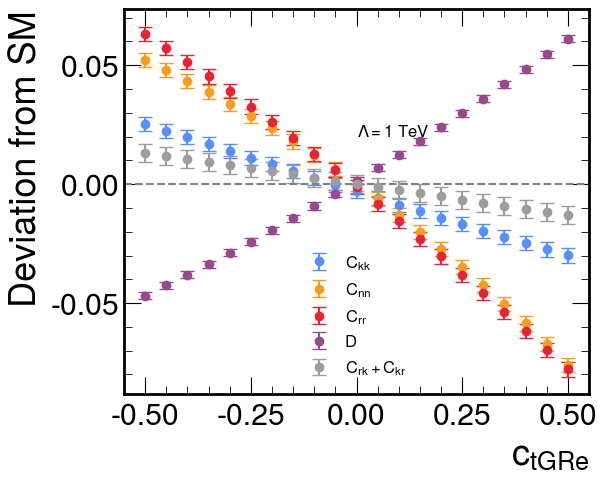

In [11]:
# Plot results

fig, ax = plt.subplots(figsize=(6,5))
wc_values = np.linspace(-0.5, 0.5, 21)
for obs_name, dev_values in deviations.items():
    ax.errorbar(wc_values, dev_values, yerr=deviations_error[obs_name], marker='o', linestyle='none', label=obs_name, capsize=5)  # Removed line connection

ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel(r'$c_{tGRe}$')
ax.set_ylabel('Deviation from SM')
ax.legend(fontsize=12)
plt.text(0, 0.02, r'$\Lambda = 1\ \rm{TeV}$', fontsize=12)

plt.show()


In [33]:
import Event_weight_prediction
import numpy as np

#compute the event weight for 



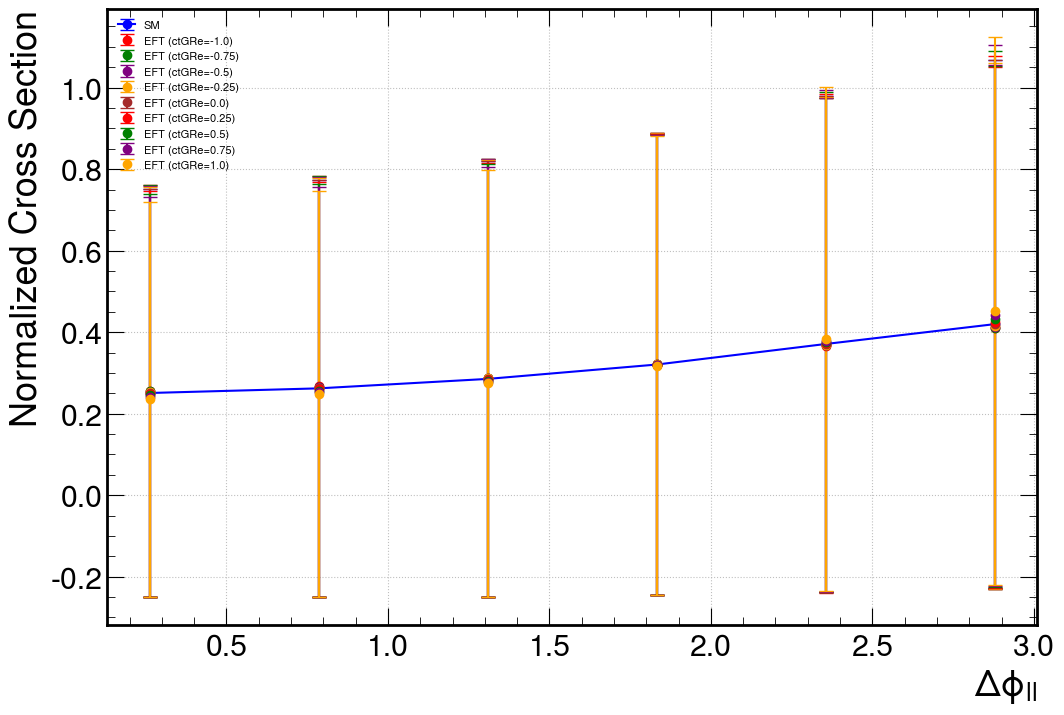

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep

def compute_test_statistics_1D(x_obs, weight_sm, weight_ctgRe_dict, bins):
    """Compute test statistics for different ctGRe values using only cos(phi)."""


    # Convert Awkward arrays to NumPy
    x_obs_np = ak.to_numpy(x_obs)
    weight_sm_np = ak.to_numpy(weight_sm)
    
    # Determine bin edges based on observable range
    min_val, max_val = ak.min(x_obs_np), ak.max(x_obs_np)
    bin_edges = np.linspace(min_val, max_val, bins + 1)
    
    # Compute SM histogram (acts as observed data)
    hist_sm, bin_edges = np.histogram(x_obs_np, bins=bin_edges, weights=weight_sm_np, density=True)
    
    # Compute statistical uncertainty
    hist_sm_err = np.sqrt(hist_sm + 1e-6)  # Small offset to avoid sqrt(0)
    
    eft_events = {}
    eft_errors = {}

    # Iterate over different ctGRe values
    for ctgRe_value, weight_eft in weight_ctgRe_dict.items():
        weight_eft_np = ak.to_numpy(weight_eft)

        # Compute EFT histogram for this ctGRe (expected under EFT)
        hist_eft, _ = np.histogram(x_obs_np, bins=bin_edges, weights=weight_eft_np, density=True)
        
        # Compute error for EFT histogram
        hist_eft_err = np.sqrt(hist_eft + 1e-6)

        # Store histogram and error for each WC value
        eft_events[ctgRe_value] = hist_eft
        eft_errors[ctgRe_value] = hist_eft_err

    return hist_sm, hist_sm_err, eft_events, eft_errors, bin_edges

# Define binning and compute test statistics
bins = 6
hist_sm, hist_sm_err, eft_events, eft_errors, bin_edges = compute_test_statistics_1D(
    file['gen_llbar_delta_phi'][mask_file],  
    weight_sm1, 
    event_weights_ctgRe,
    bins
)

plt.style.use(hep.style.CMS)
# Plot normalized cross-section for cos(phi)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.figure(figsize=(12, 8))

# SM with error bars
plt.errorbar(bin_centers, hist_sm, yerr=hist_sm_err, fmt='o', linestyle='-',label="SM", capsize=5, color='blue')

# Plot EFT variations with error bars
colors = ['red', 'green', 'purple', 'orange', 'brown']
for i, (ctgRe_value, hist_eft) in enumerate(eft_events.items()):
    hist_eft_err = eft_errors[ctgRe_value]
    plt.errorbar(bin_centers, hist_eft, yerr=hist_eft_err, fmt='o', linestyle='', capsize=5, 
                 color=colors[i % len(colors)], label=f"EFT (ctGRe={ctgRe_value})")

plt.xlabel(r'$\Delta\phi_{ll}$')
plt.ylabel("Normalized Cross Section")
plt.legend(fontsize=8)
plt.grid()
plt.show()


In [77]:
hist_sm_err

array([0.64193521, 0.64489588, 0.64537979, 0.65096183, 0.65047398,
       0.65244734, 0.65766571, 0.65673434, 0.66008565, 0.66728078,
       0.6683696 , 0.6708897 , 0.67078399, 0.67002359, 0.67222747,
       0.6768106 , 0.67640921, 0.68102444, 0.68285527, 0.68523185,
       0.68725372, 0.69063261, 0.69166374, 0.69140162, 0.69771647,
       0.69712096, 0.69732803, 0.70309143, 0.70759915, 0.70701286,
       0.7080116 , 0.70917309, 0.71357555, 0.71204171, 0.71440667,
       0.71587769, 0.7204237 , 0.72333828, 0.7245858 , 0.7255288 ,
       0.72770748, 0.72955543, 0.73364058, 0.73455897, 0.73502033,
       0.739864  , 0.74115064, 0.74314918, 0.74594768, 0.74555025,
       0.74780243, 0.74902789, 0.75292041, 0.75581907, 0.75644825,
       0.76047174, 0.75890279, 0.76331506, 0.76358998, 0.76622918])

In [35]:
import numpy as np

def compute_chi_square(hist_sm, hist_sm_err, hist_eft, hist_eft_err):
    """Compute the Chi-square statistic between SM and EFT histograms."""
    
    # Make sure both histograms have the same length
    assert len(hist_sm) == len(hist_eft), "Histograms should have the same length"
    
    # Compute Chi-square term for each bin
    chi_square = 0.0
    for i in range(len(hist_sm)):
        # Total uncertainty (sqrt of squares of individual errors)
        total_error = np.sqrt(hist_sm_err[i]**2 + hist_eft_err[i]**2)
        
        # Only consider bins where the uncertainty is non-zero to avoid division by zero
        if total_error > 0:
            chi_square += ((hist_sm[i] - hist_eft[i])**2) / total_error**2
    
    return chi_square

# Compute Chi-square for each EFT variation
test_statistics = {}

for ctgRe_value, hist_eft in eft_events.items():
    hist_eft_err = eft_errors[ctgRe_value]
    
    # Compute Chi-square for this EFT variation
    chi_square_value = compute_chi_square(hist_sm, hist_sm_err, hist_eft, hist_eft_err)
    test_statistics[ctgRe_value] = chi_square_value



In [36]:
test_statistics

{-1.0: 0.00024567925430878665,
 -0.75: 0.00019271601484329917,
 -0.5: 0.00011784660067142332,
 -0.25: 4.002040951639238e-05,
 0.0: 1.798374997704628e-11,
 0.25: 7.137542664247746e-05,
 0.5: 0.00037326306968345506,
 0.75: 0.0010821695834830128,
 1.0: 0.002438198364091799}

In [52]:
import numpy as np
import awkward as ak

def compute_test_statistics_2D(x_obs, y_obs, weight_sm, weight_ctgRe_dict, bins):
    """Compute test statistics using the likelihood ratio method for different ctGRe values"""

    # Define 2D binning
    x_bins = np.linspace(-1, 1, bins + 1)  
    y_bins = np.linspace(350, 1000, bins + 1)    

    # Convert Awkward arrays to NumPy
    x_obs_np = ak.to_numpy(x_obs)
    y_obs_np = ak.to_numpy(y_obs)
    weight_sm_np = ak.to_numpy(weight_sm)

    # Compute SM histogram (acts as observed data)
    hist_sm, _, _ = np.histogram2d(x_obs_np, y_obs_np, bins=[x_bins, y_bins], weights=weight_sm_np, density=True)
    test_statistics = {}

    # Iterate over different ctGRe values
    for ctgRe_value, weight_eft in weight_ctgRe_dict.items():
            
        weight_eft_np = ak.to_numpy(weight_eft)

        # Compute EFT histogram for this ctgRe (expected under EFT)
        hist_eft, _, _ = np.histogram2d(x_obs_np, y_obs_np, bins=[x_bins, y_bins], weights=weight_eft_np, density=True)
        
        # Avoid division by zero and log(0)
        epsilon = 1e-15
        hist_sm = np.where(hist_sm == 0, epsilon, hist_sm)
        hist_eft = np.where(hist_eft == 0, epsilon, hist_eft)

        # Compute test statistic: Wilks' theorem based likelihood ratio
        test_statistic = -2 * np.sum(hist_sm * np.log(hist_eft / hist_sm) + (hist_sm - hist_eft))

        # Store test statistic
        test_statistics[ctgRe_value] = test_statistic

    return test_statistics

bins=4
# Compute test statistics
test_statistics = compute_test_statistics_2D(
    file['gen_ll_cHel'][mask_file], 
    file['gen_ttbar_mass'][mask_file], 
    weight_sm, 
    event_weights_ctgRe,
    bins
)



In [53]:
test_statistics

{-1.0: 5.010518651100612,
 -0.8333333333333334: 3.608489975848011,
 -0.6666666666666667: 2.3993829005991874,
 -0.5: 1.4061210767977512,
 -0.33333333333333337: 0.6530996342777192,
 -0.16666666666666674: 0.17160339578454742,
 0.0: -9.73516746445471e-16,
 0.16666666666666652: 0.19161435286542772,
 0.33333333333333326: 0.8170446254565704,
 0.5: 1.9754277183309248,
 0.6666666666666665: 3.7914961022905262,
 0.8333333333333333: 6.410195817615616,
 1.0: 9.99354292744687}

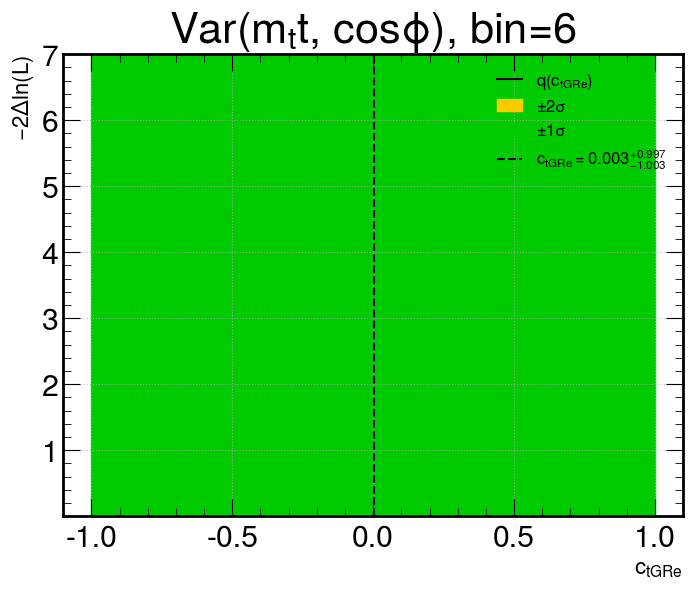

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Convert to arrays for plotting
ctgRe_values = np.array(list(test_statistics.keys()))
test_stat_values = np.array(list(test_statistics.values()))

# Interpolating the test statistic function for smoothness
interp_func = interp1d(ctgRe_values, test_stat_values, kind='cubic', fill_value="extrapolate")

# Fine grid for smooth curve
fine_ctgRe = np.linspace(min(ctgRe_values), max(ctgRe_values), 300)
fine_test_stat = interp_func(fine_ctgRe)

# Find best-fit value (minimum of test statistic)
best_fit_idx = np.argmin(fine_test_stat)
best_fit_ctgRe = fine_ctgRe[best_fit_idx]
best_fit_stat = fine_test_stat[best_fit_idx]

sigma1_mask = (fine_test_stat >= best_fit_stat) & (fine_test_stat <= best_fit_stat + 1)
sigma2_mask = (fine_test_stat >= best_fit_stat + 1) & (fine_test_stat <= best_fit_stat + 4)


sigma1_range = fine_ctgRe[sigma1_mask]
sigma2_range = fine_ctgRe[sigma2_mask]

# Plot
plt.figure(figsize=(8,6))
plt.plot(fine_ctgRe, fine_test_stat, 'k-', label=r'$q(c_{tGRe})$')

# Shading for 1σ and 2σ intervals
plt.fill_between(sigma2_range, best_fit_stat, 10, color='#FFCB00', label=r'$\pm2\sigma$')  # Orange
plt.fill_between(sigma1_range, best_fit_stat, 10, color='#00CB00', label=r'$\pm1\sigma$')  # Green

best_fit_str = rf"$c_{{tGRe}} = {best_fit_ctgRe:.3f}^{{+{max(sigma1_range)-best_fit_ctgRe:.3f}}}_{{-{best_fit_ctgRe-min(sigma1_range):.3f}}}$"

# Dashed line for best fit
plt.axvline(best_fit_ctgRe, color='k', linestyle='--', label=f"{best_fit_str}")

# Labels
plt.xlabel(r'$c_{tGRe}$', fontsize=16)
plt.ylabel(r' $-2\Delta ln(L)$', fontsize=16)
plt.title(f'Var($m_tt$, $cos \phi$), bin={bins}')
# Set y-axis limits from the minimum value of the function to zero
plt.ylim(best_fit_stat, 7)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
